In [99]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import ast
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as pe
import math
import datetime
from dateutil.relativedelta import relativedelta
import random

In [5]:
## Matplotlib defaults

plt.style.use("default")

plt.rcParams.update({"font.size" : 22})

palette = ["#e072b5",
"#69b15f",
"#737df6",
"#c79737",
"#b67ae4",
"#e57368",
"#799ddb"]

# Full "Causality" figure

Why does MA increase over time? Explores:

1. Cost
2. Network degree
3. Individual authors
4. Companies (assignees)
5. Patent classifications

## Novel compounds

Goal is to show how novel compounds are driving MA changes...

In [13]:
MA_df_months = pd.read_csv("../Data/AssemblyValues/MA_df_months.csv")
MA_df_months["date"] = pd.to_datetime(MA_df_months["date"])
MA_df_months["month"] = MA_df_months["month"].to_string()
MA_df_months["avg"] = pd.to_numeric(MA_df_months["avg"])

MA_df_months = MA_df_months[MA_df_months["date"] >= "1980"]

In [14]:
def get_month(label):
    """ Isolates the month from the given label

    Args:
        label (str): compound id in the form YYYY-MM_label

    Returns:
        str: YYYY-MM of a particular compound
    """
    return str(label)[:7]

In [32]:
new_df = pd.read_csv("../Data/AssemblyValues/NewDatabase_AssemblyGo.csv")
new_df["month"] = new_df["label"].apply(get_month)
new_df = new_df.dropna()

new_stats = new_df.groupby(["month"]).agg({"MA_assemblyGo":["mean","std"]})
new_stats = new_stats.dropna(axis=0)


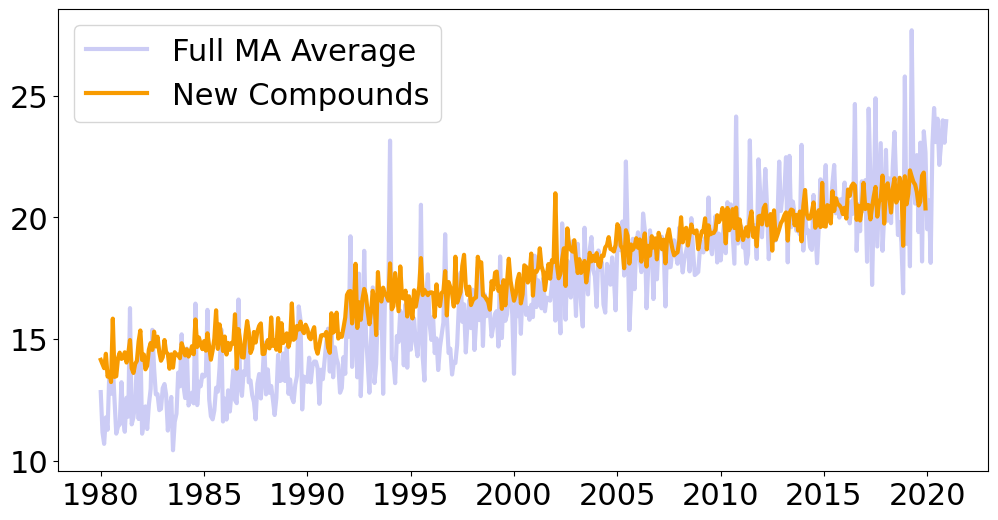

In [36]:
plt.figure(figsize=(12,6))

plt.plot(MA_df_months["date"], MA_df_months["avg"], color="mediumblue",
            linewidth=3, markersize=10, alpha=0.2, label="Full MA Average")

plt.plot(list(MA_df_months["date"])[:-12], new_stats["MA_assemblyGo"]["mean"], color="#f89b00",
            linewidth=3, markersize=10, label="New Compounds")

plt.legend()

## Cost

Individually plot cost figure

In [3]:
cost_df = pd.read_csv("/Volumes/Macintosh HD 4/SureChemBL/Cost/random_cost_50k_MA.csv")

print(cost_df)

       Unnamed: 0  Unnamed: 0.1           CAS     price  \
0               0        312645     2446-69-7   13.5664   
1               1        217713           NaN   75.9000   
2               2        144938     1759-55-3   58.8000   
3               3         81564  2095410-18-5  421.1000   
4               4        171801  1864299-18-2  169.3000   
...           ...           ...           ...       ...   
49995       49995         14022    21243-02-7  130.0000   
49996       49996         18129  1057326-92-7  151.7000   
49997       49997        214453   923034-27-9  403.5000   
49998       49998         11443    50617-74-8  151.7000   
49999       49999        308529  1214900-87-4  867.3600   

                                                    name    supplier  \
0                           4-Hexylphenol >= 98.0 % HPLC       sigma   
1                    3,6-dichloropyrazine-2-carbonitrile     enamine   
2                 2,2-dimethylcyclopropane-1-carboxamide     enamine   
3  

In [4]:
## Remove all "unfinished" MA calculations - unfinished are those that didn't finish in 300 seconds

cost_df_filtered = cost_df[cost_df["time"] <= 299]

## Also removing all -1 MA values
cost_df_filtered = cost_df_filtered[cost_df_filtered["MA"] > 0]

print(cost_df_filtered)

       Unnamed: 0  Unnamed: 0.1           CAS     price  \
0               0        312645     2446-69-7   13.5664   
1               1        217713           NaN   75.9000   
2               2        144938     1759-55-3   58.8000   
3               3         81564  2095410-18-5  421.1000   
4               4        171801  1864299-18-2  169.3000   
...           ...           ...           ...       ...   
49995       49995         14022    21243-02-7  130.0000   
49996       49996         18129  1057326-92-7  151.7000   
49997       49997        214453   923034-27-9  403.5000   
49998       49998         11443    50617-74-8  151.7000   
49999       49999        308529  1214900-87-4  867.3600   

                                                    name    supplier  \
0                           4-Hexylphenol >= 98.0 % HPLC       sigma   
1                    3,6-dichloropyrazine-2-carbonitrile     enamine   
2                 2,2-dimethylcyclopropane-1-carboxamide     enamine   
3  

In [5]:
## Testing - changing cost to log scale
cost_df_filtered["log_price"] = np.log(cost_df_filtered["price"])

print(cost_df_filtered)

       Unnamed: 0  Unnamed: 0.1           CAS     price  \
0               0        312645     2446-69-7   13.5664   
1               1        217713           NaN   75.9000   
2               2        144938     1759-55-3   58.8000   
3               3         81564  2095410-18-5  421.1000   
4               4        171801  1864299-18-2  169.3000   
...           ...           ...           ...       ...   
49995       49995         14022    21243-02-7  130.0000   
49996       49996         18129  1057326-92-7  151.7000   
49997       49997        214453   923034-27-9  403.5000   
49998       49998         11443    50617-74-8  151.7000   
49999       49999        308529  1214900-87-4  867.3600   

                                                    name    supplier  \
0                           4-Hexylphenol >= 98.0 % HPLC       sigma   
1                    3,6-dichloropyrazine-2-carbonitrile     enamine   
2                 2,2-dimethylcyclopropane-1-carboxamide     enamine   
3  

SpearmanrResult(correlation=0.12541840009179364, pvalue=4.3269813358019165e-161)


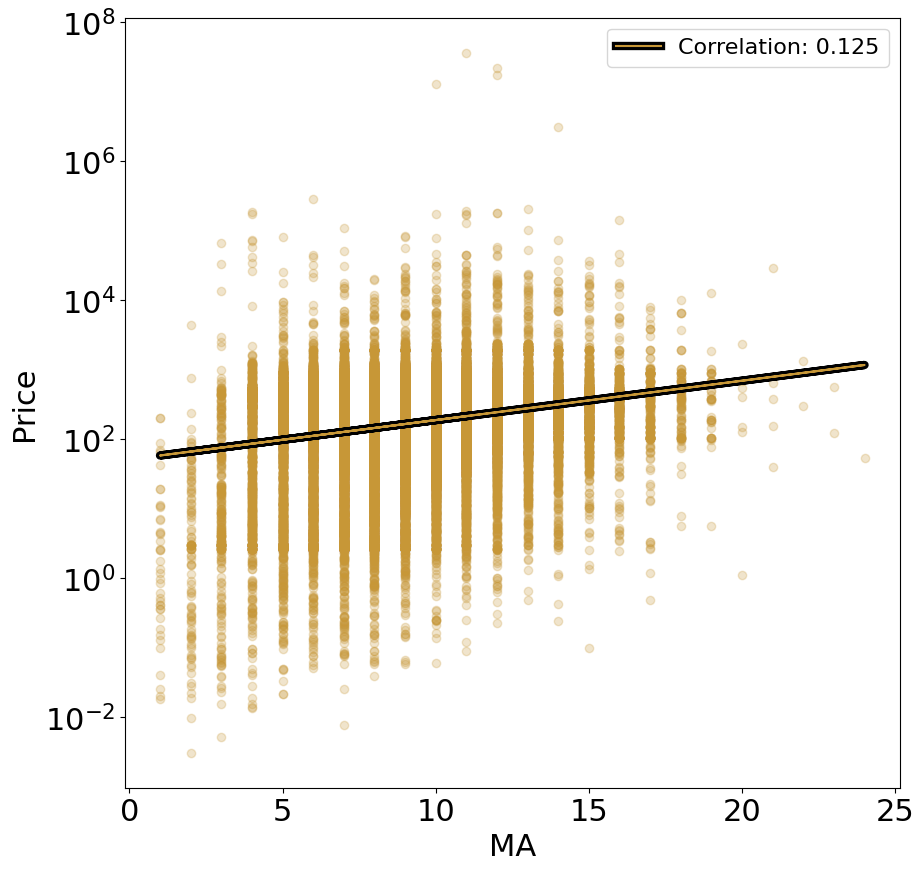

In [12]:
plt.figure(figsize=(10,10))

plt.yscale("log")

cost_df_filtered = cost_df_filtered.sort_values("price")

plt.scatter(cost_df_filtered["MA"], cost_df_filtered["price"], alpha=0.25, color=palette[3])
# sns.kdeplot(data=cost_df_filtered, x="MA", y="price", fill=True, color="seagreen", alpha=0.5)

#plt.plot(X, Y_pred, linewidth=3, color="springgreen")
slope, intercept = np.polyfit(cost_df_filtered["MA"], np.log(cost_df_filtered["price"]), 1)

##Calculate Pearson correlation & Spearman (not assuming normality)
spearman_corr = stats.spearmanr(cost_df_filtered["MA"], cost_df_filtered["price"])

plt.plot(cost_df_filtered["MA"], np.exp((slope*cost_df_filtered["MA"]) + intercept), color=palette[3],
        label="Correlation: " + str(round(spearman_corr[0], 3)), 
        path_effects=[pe.Stroke(linewidth=6, foreground="k"), pe.Normal()])

print(spearman_corr)

plt.xlabel("MA")
plt.ylabel("Price")
plt.legend(prop={"size":16})

### Cost Bootstrapping

In [7]:
#Store spearman correlation (if this goes below 0, then I'm confident it's not correlated)
corrs = []
p_values = []

for i in tqdm(range(1000)):
    # Keep 80% of sample each bootstrap
    sub_df = cost_df_filtered.sample(frac=0.8)
    spearman_corr = stats.spearmanr(sub_df["MA"], sub_df["price"])

    corrs.append(spearman_corr[0])
    p_values.append(spearman_corr[1])

100%|██████████| 1000/1000 [00:24<00:00, 40.98it/s]


Text(0.5, 0, 'Sample')

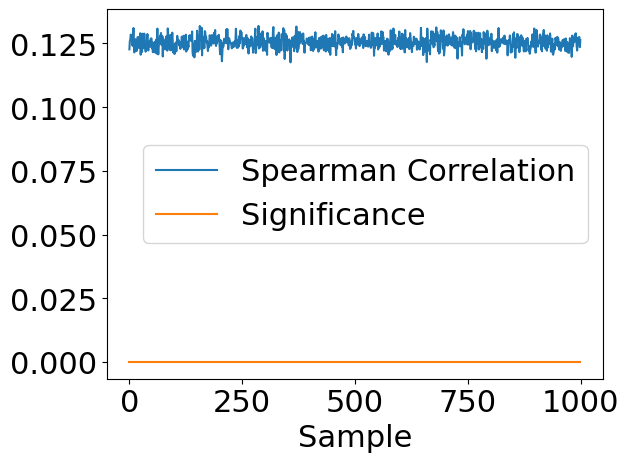

In [8]:
plt.plot(corrs, label="Spearman Correlation")
plt.plot(p_values, label="Significance")

plt.legend()

plt.xlabel("Sample")


## Network figure

In [13]:
#Read in assembly data into a dictionary, {ID:MA_value}
MA_df = pd.read_csv("../Data/AssemblyValues/assigneeCpds_AssemblyGo.csv")
assignee_cpd_MA_links = dict(zip(MA_df["label"], MA_df["MA_assemblyGo"]))

MA_df = pd.read_csv("../Data/AssemblyValues/authorcpds_AssemblyGo.csv")
author_cpd_MA_links = dict(zip(MA_df["label"], MA_df["MA_assemblyGo"]))

cpd_MA_links = {**assignee_cpd_MA_links, **author_cpd_MA_links}

MA_df = pd.DataFrame(cpd_MA_links.items(), columns=["label", "MA_assemblyGo"])

print(MA_df)

                   label  MA_assemblyGo
0        SCHEMBL10000004           13.0
1        SCHEMBL10000028           25.0
2        SCHEMBL10000029           20.0
3        SCHEMBL10000030           20.0
4        SCHEMBL10000031           19.0
...                  ...            ...
2711114   SCHEMBL9999904           15.0
2711115    SCHEMBL999991            7.0
2711116   SCHEMBL9999925           13.0
2711117   SCHEMBL9999926           14.0
2711118    SCHEMBL999994            7.0

[2711119 rows x 2 columns]


In [14]:
### ID/Degree relation: use 2015-2019 full ID list to find final degree value
full_id_degrees = pickle.load(file=open("/Volumes/Macintosh HD 4/SureChemBL/Degrees/full_id_degrees_2015_2019.p", "rb"))

print(list(full_id_degrees.items())[0:5])

[('SCHEMBL8038039', [418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418]), ('SCHEMBL656810', [1877, 1877, 1877, 3744, 7513, 9389, 9389, 9389, 13151, 15023, 16895, 16895, 20644, 20644, 20644, 20644, 22525, 22525, 22525, 24406, 24406, 24406, 26278, 26278, 28153, 28153, 31932, 31932, 31932, 33832, 33832, 35734, 35734, 35734, 35734, 35734, 35734, 35734, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 39493, 39493, 43224, 43224, 43224, 43224, 43224]), ('SCHEMBL16387018', [103, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201

In [15]:
def get_degree(ID, full_id_degrees):
    if ID in full_id_degrees:
        return full_id_degrees[ID][-1]
    else:
        return -1

In [16]:
#Add degree values to MA dataframe
tqdm.pandas()

MA_df["degree"] = MA_df["label"].progress_apply(get_degree, args=(full_id_degrees,))

/usr/local/lib/python3.9/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████████████████████████| 2711119/2711119 [00:43<00:00, 61902.27it/s]


In [17]:
del(full_id_degrees)

In [18]:
#Filter out all -1 MAs (indicates these MAs were not sampled)

MA_df_filtered = MA_df[MA_df["MA_assemblyGo"] > 0]

## Also where degrees are greater than 0

MA_df_filtered = MA_df_filtered[MA_df_filtered["degree"] > 0]


SpearmanrResult(correlation=-0.05327862379369209, pvalue=0.0)


/usr/local/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


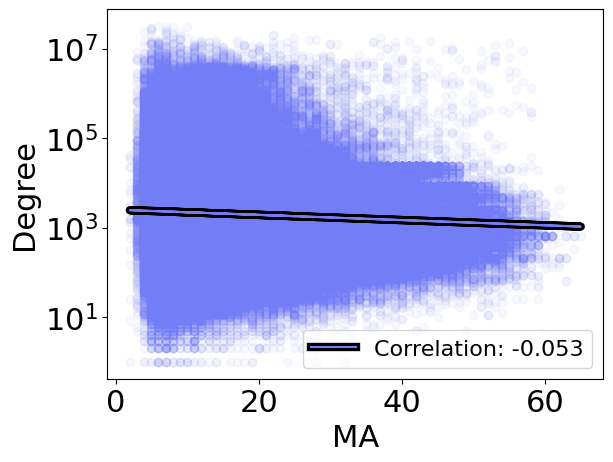

In [19]:
#Visual representation of 0 correlation (lol)
plt.Figure(figsize=(10,10))

plt.yscale("log")

plt.scatter(MA_df_filtered["MA_assemblyGo"], MA_df_filtered["degree"], color=palette[2], alpha=0.05)
# sns.kdeplot(data=MA_df_filtered, x="MA_assemblyGo", y="degree", fill=True, color="cadetblue", alpha=0.5)

#plt.plot(X, Y_pred, linewidth=3, color="springgreen")
slope, intercept = np.polyfit(MA_df_filtered["MA_assemblyGo"], np.log(MA_df_filtered["degree"]), 1)

##Calculate Spearman correlation (not assuming normality)
spearman_corr = stats.spearmanr(MA_df_filtered["MA_assemblyGo"], MA_df_filtered["degree"])

plt.plot(MA_df_filtered["MA_assemblyGo"], np.exp((slope*MA_df_filtered["MA_assemblyGo"]) + intercept), 
        color=palette[2], label="Correlation: " + str(round(spearman_corr[0], 3)),
        path_effects=[pe.Stroke(linewidth=6, foreground="k"), pe.Normal()])

print(spearman_corr)

plt.xlabel("MA")
plt.ylabel("Degree")
plt.legend(prop={"size":16})

In [12]:
#Store spearman correlation (if this goes below 0, then I'm confident it's not correlated)
corrs = []
p_values = []

for i in tqdm(range(1000)):
    # Keep 80% of sample each bootstrap
    sub_df = MA_df_filtered.sample(frac=0.8)
    spearman_corr = stats.spearmanr(sub_df["MA_assemblyGo"], sub_df["degree"])

    corrs.append(spearman_corr[0])
    p_values.append(spearman_corr[1])

100%|██████████| 1000/1000 [05:40<00:00,  2.94it/s]


Text(0.5, 1.0, 'Degree/MA Bootstrap')

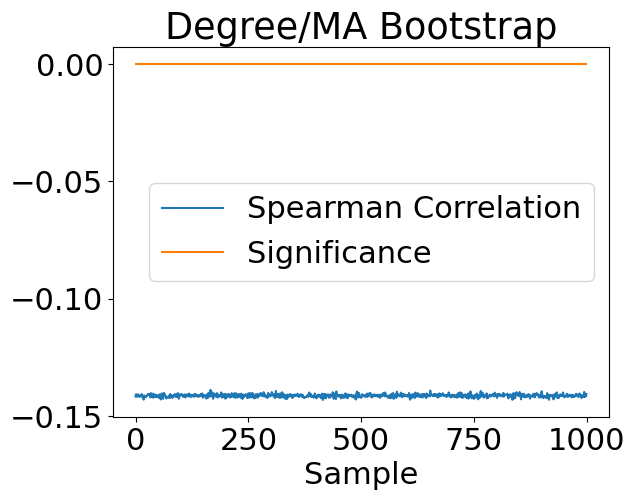

In [13]:
plt.plot(corrs, label="Spearman Correlation")
plt.plot(p_values, label="Significance")

plt.legend()

plt.xlabel("Sample")
plt.title("Degree/MA Bootstrap")


### Individual Researchers

In [6]:
results_df = pd.read_csv("../Data/Patents/patent_MA_results.csv")

In [8]:
results_df.head()

,Unnamed: 0,Unnamed: 0.1,ID,author,assignees,MAs,MA_avg,MA_max,classification,date,date_ordinal
0,0,276,US-10034442-B2,AARDEN HARRIETTE,SEMINIS_VEGETABLE_SEEDS_INC,"[6.0, 7.0, 6.0]",6.333333,7.0,"['A01H5/00', 'A01H5/08', 'C12N15/00', 'C12Q1/6...",2018-07-31,736906
1,10,277,US-10034442-B2,BAR AMI,SEMINIS_VEGETABLE_SEEDS_INC,"[6.0, 7.0, 6.0]",6.333333,7.0,"['A01H5/00', 'A01H5/08', 'C12N15/00', 'C12Q1/6...",2018-07-31,736906
2,20,278,US-10034442-B2,GRIT ALBERT,SEMINIS_VEGETABLE_SEEDS_INC,"[6.0, 7.0, 6.0]",6.333333,7.0,"['A01H5/00', 'A01H5/08', 'C12N15/00', 'C12Q1/6...",2018-07-31,736906
3,30,279,US-10034442-B2,HOTZEV AMIT,SEMINIS_VEGETABLE_SEEDS_INC,"[6.0, 7.0, 6.0]",6.333333,7.0,"['A01H5/00', 'A01H5/08', 'C12N15/00', 'C12Q1/6...",2018-07-31,736906
4,40,280,US-10034442-B2,OSRI ARNON,SEMINIS_VEGETABLE_SEEDS_INC,"[6.0, 7.0, 6.0]",6.333333,7.0,"['A01H5/00', 'A01H5/08', 'C12N15/00', 'C12Q1/6...",2018-07-31,736906


In [7]:
counts = results_df["author"].value_counts()
print("Num authors:", len([x for x in counts if x >= 10]))

Num authors: 2793


2793


100%|█████████████████████████████████████| 71587/71587 [23:09<00:00, 51.53it/s]


Text(0, 0.5, 'Patents')

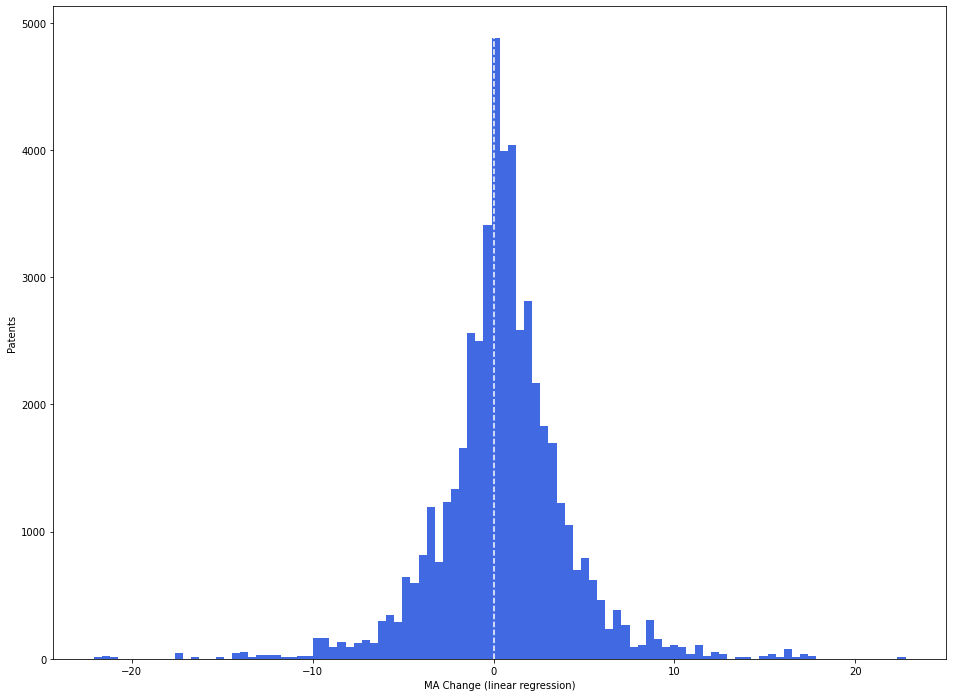

In [6]:
#Alternative graphing (finding slope change in MA)
linear_regressor = LinearRegression()

author_MA_slopes = []

for author in tqdm(list(results_df["author"].unique())):
    sub_df = results_df[results_df["author"] == author]
    if len(sub_df) > 10:

        X = sub_df["date_ordinal"].values.reshape(-1,1)
        Y = sub_df["MA_avg"].values.reshape(-1,1)
        try:
            reg = linear_regressor.fit(X, Y)
            Y_pred = linear_regressor.predict(X)

            #Calculate deltaMA (change in MA of linear regression, taking into consideration negative slopes)
            author_MA_slopes.extend([reg.coef_[0][0] * (max(X) - min(X))[0]] * len(sub_df))
                        
        except ValueError as e:
            pass

plt.figure(figsize=(16,12))


plt.hist(author_MA_slopes, bins=100, color="royalblue")
plt.axvline(x=0, ymin=0, ymax=70, color="white", linestyle="--")
plt.xlabel("MA Change (linear regression)")
plt.ylabel("Patents")
# plt.title("Average MA changes - Authors", color="skyblue")


In [29]:
# Check percentile of 0
print("Percentile of 0 value", stats.percentileofscore(author_MA_slopes, 0, kind="rank"))
print("Mean:", np.mean(author_MA_slopes))
print("Std:", np.std(author_MA_slopes))

Percentile of 0 value 40.3304372030141
Mean: 0.5141305491772047
Std: 3.6134512536558443


## Assignees

100%|█████████████████████████████████████████| 833/833 [00:17<00:00, 48.43it/s]


185601


Text(0, 0.5, 'Patents')

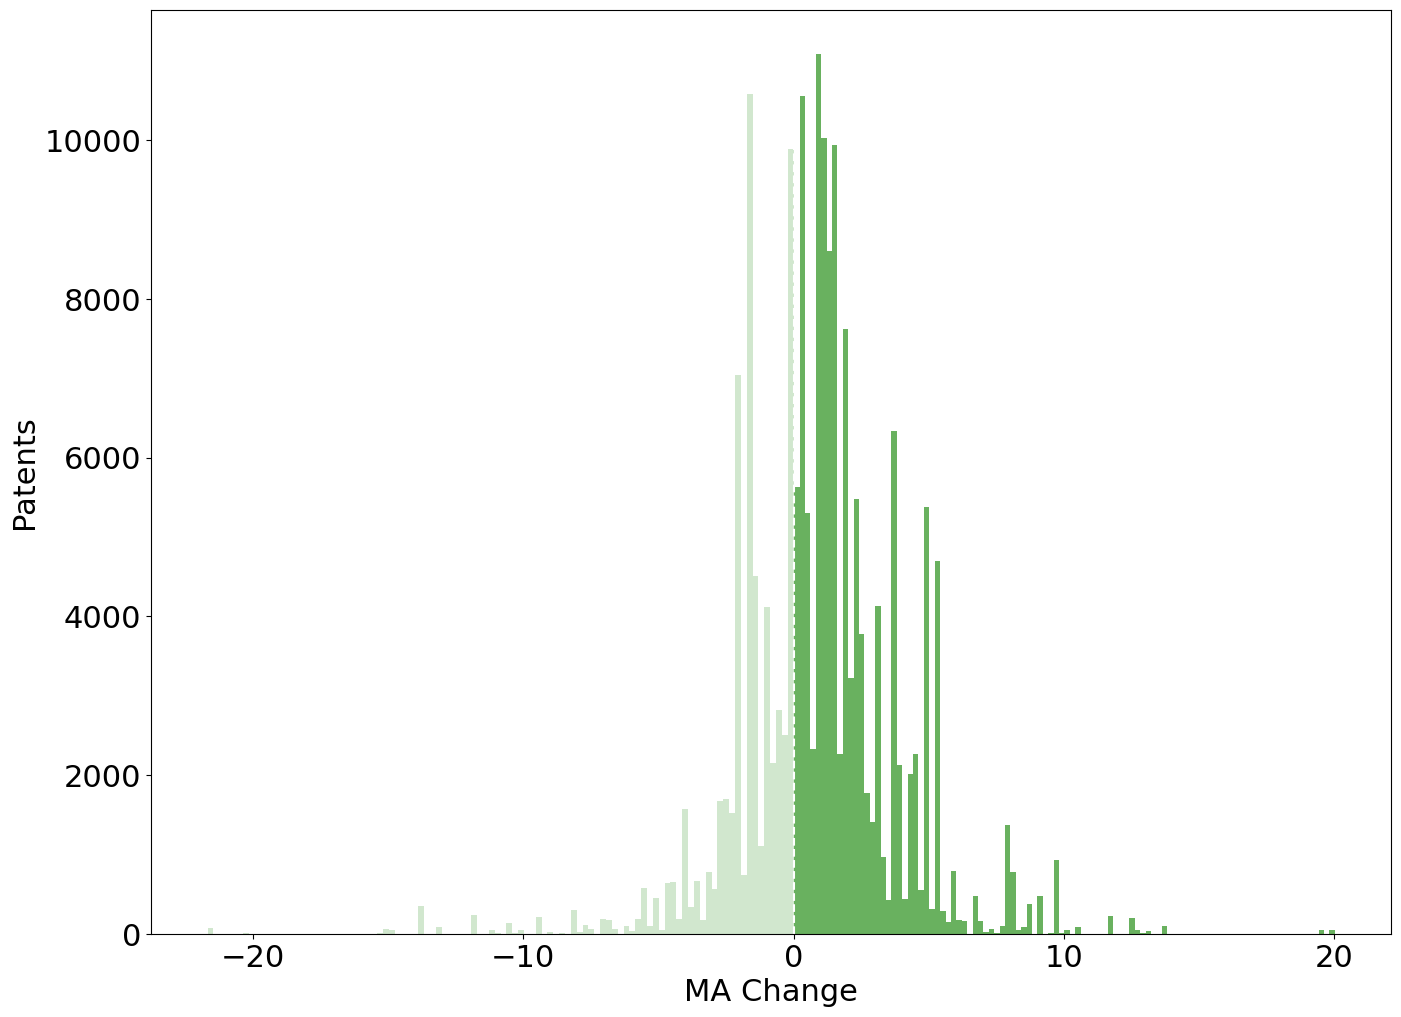

In [23]:
#Alternative graphing (finding slope change in MA)
linear_regressor = LinearRegression()

assignee_MA_slopes = []
counts = []

for assignee in tqdm(list(results_df["assignees"].unique())):
    sub_df = results_df[results_df["assignees"] == assignee]
    if len(sub_df) > 10:

        X = sub_df["date_ordinal"].values.reshape(-1,1)
        Y = sub_df["MA_avg"].values.reshape(-1,1)
        try:
            reg = linear_regressor.fit(X, Y)
            Y_pred = linear_regressor.predict(X)

            r2 = reg.score(X, Y)

            assignee_MA_slopes.extend([reg.coef_[0][0] * (max(X) - min(X))[0]]*len(sub_df))
                        
        except ValueError as e:
            pass
        
print(len(assignee_MA_slopes))

plt.figure(figsize=(16,12))

plt.hist([x for x in assignee_MA_slopes if x <= 0], bins=100, histtype="bar", color=palette[1], alpha=0.3)
plt.hist([x for x in assignee_MA_slopes if x > 0], bins=100, histtype="bar", color=palette[1])

plt.axvline(x=0, ymin=0, ymax=70, color="white", linestyle="--")
plt.xlabel("MA Change")
plt.ylabel("Patents")
# plt.title("Average MA changes - Assignees", color="indianred")


100%|██████████| 833/833 [00:13<00:00, 61.99it/s]


Text(0, 0.5, 'Patents')

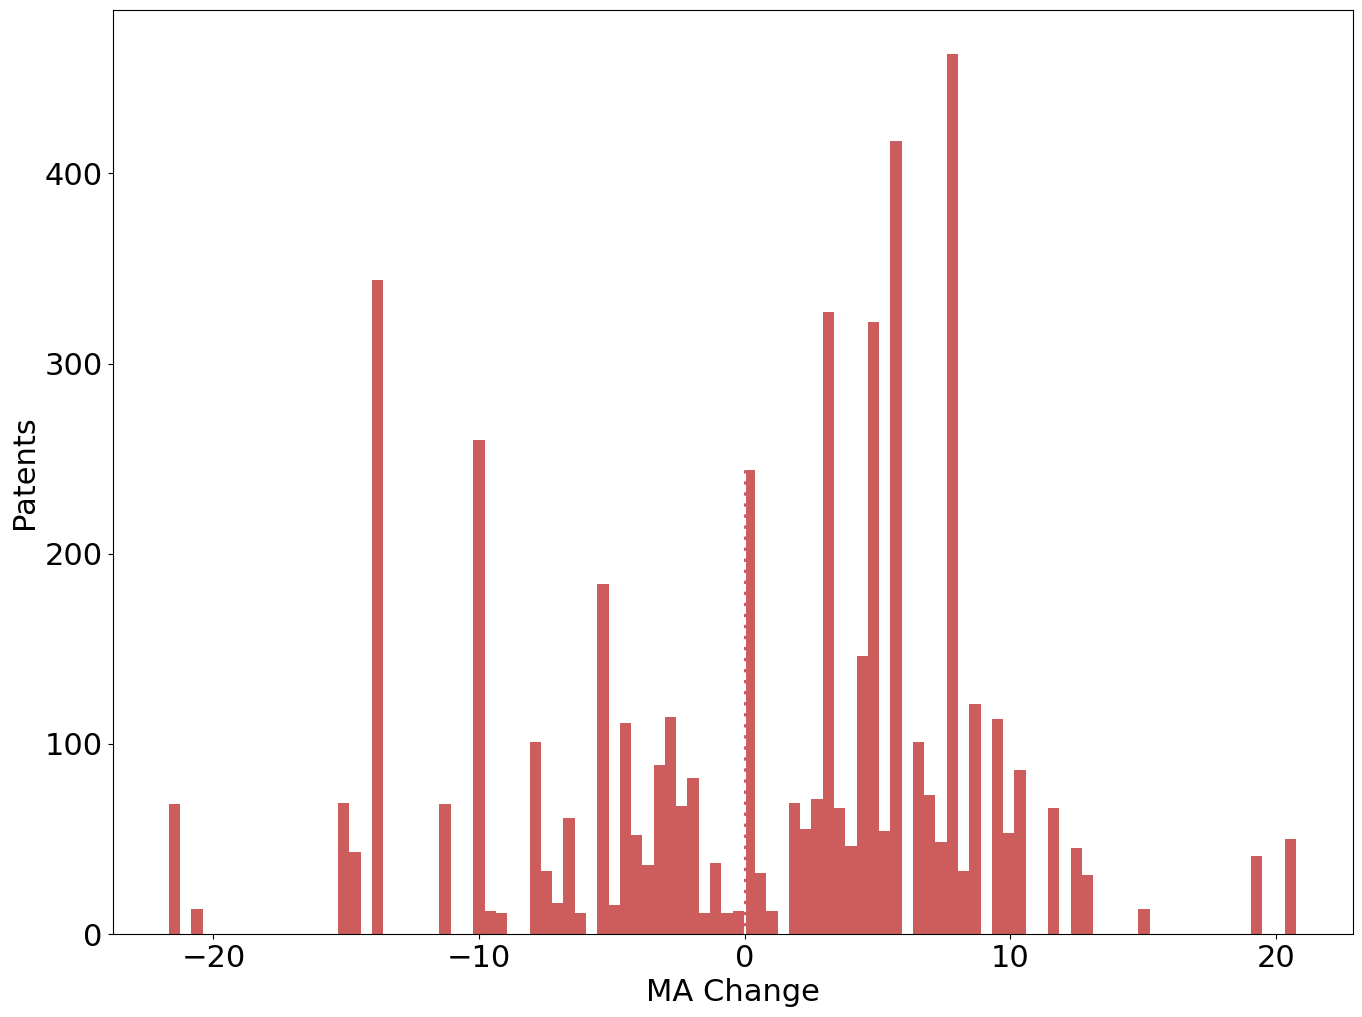

In [5]:
#Alternative graphing (finding slope change in MA)
linear_regressor = LinearRegression()

assignee_MA_slopes = []
counts = []

for assignee in tqdm(list(results_df["assignees"].unique())):
    sub_df = results_df[results_df["assignees"] == assignee]
    if len(sub_df) > 10:

        X = sub_df["date_ordinal"].values.reshape(-1,1)
        Y = sub_df["MA_avg"].values.reshape(-1,1)
        try:
            reg = linear_regressor.fit(X, Y)
            Y_pred = linear_regressor.predict(X)

            r2 = reg.score(X, Y)

            if (r2 >= 0.25):

                #Calculate deltaMA (change in MA of linear regression, taking into consideration negative slopes)
                assignee_MA_slopes.extend([reg.coef_[0][0] * (max(X) - min(X))[0]]*len(sub_df))
                        
        except ValueError as e:
            pass

plt.figure(figsize=(16,12))


plt.hist(assignee_MA_slopes, bins=100, histtype="bar", color="indianred")
plt.axvline(x=0, ymin=0, ymax=70, color="white", linestyle="--")
plt.xlabel("MA Change")
plt.ylabel("Patents")
# plt.title("Average MA changes - Assignees", color="indianred")


In [28]:
# Check percentile of 0
print("Percentile of 0 value", stats.percentileofscore(assignee_MA_slopes, 0, kind="rank"))
print("Mean:", np.mean(assignee_MA_slopes))
print("Std:", np.std(assignee_MA_slopes))

Percentile of 0 value 32.08522583391253
Mean: 0.9944440979489239
Std: 2.951451200625727


## Classification

In [10]:
def classification_to_list(classification):
    try:
        return ast.literal_eval(classification)
    except ValueError:
        return []
    except SyntaxError:
        return classification.strip('][').split(',')

In [11]:
tqdm.pandas()

results_df["classification"] = results_df["classification"].progress_apply(classification_to_list)

100%|██████████| 186485/186485 [00:04<00:00, 42022.45it/s]


In [12]:
#Explode classifications
results_df = results_df.explode("classification")

In [13]:
## Remove backslash and two numbers after it (and put them in a different column, in case they are useful later...)
def filter_classification(classification):
    try:
        return classification.split("/")[0]
    except AttributeError:
        return ""

In [14]:
tqdm.pandas()

results_df["filtered_classification"] = results_df["classification"].progress_apply(filter_classification)

print(results_df)

100%|██████████| 1247658/1247658 [00:01<00:00, 738287.06it/s]


        Unnamed: 0  Unnamed: 0.1              ID            author  \
0                0           276  US-10034442-B2  AARDEN HARRIETTE   
0                0           276  US-10034442-B2  AARDEN HARRIETTE   
0                0           276  US-10034442-B2  AARDEN HARRIETTE   
0                0           276  US-10034442-B2  AARDEN HARRIETTE   
1               10           277  US-10034442-B2           BAR AMI   
...            ...           ...             ...               ...   
186483     4152321        907681   US-9751966-B2    ZWEIG ANDREW M   
186483     4152321        907681   US-9751966-B2    ZWEIG ANDREW M   
186483     4152321        907681   US-9751966-B2    ZWEIG ANDREW M   
186484     4152322        907682    US-4914171-A    ZWEIG ANDREW M   
186484     4152322        907682    US-4914171-A    ZWEIG ANDREW M   

                          assignees  \
0       SEMINIS_VEGETABLE_SEEDS_INC   
0       SEMINIS_VEGETABLE_SEEDS_INC   
0       SEMINIS_VEGETABLE_SEEDS_INC   
0  

In [15]:
counts = results_df["filtered_classification"].value_counts()
print("Num classifications:", len([x for x in counts if x >= 10]))

Num classifications: 2036


100%|███████████████████████████████████████| 2926/2926 [06:54<00:00,  7.06it/s]


Text(0, 0.5, 'Count')

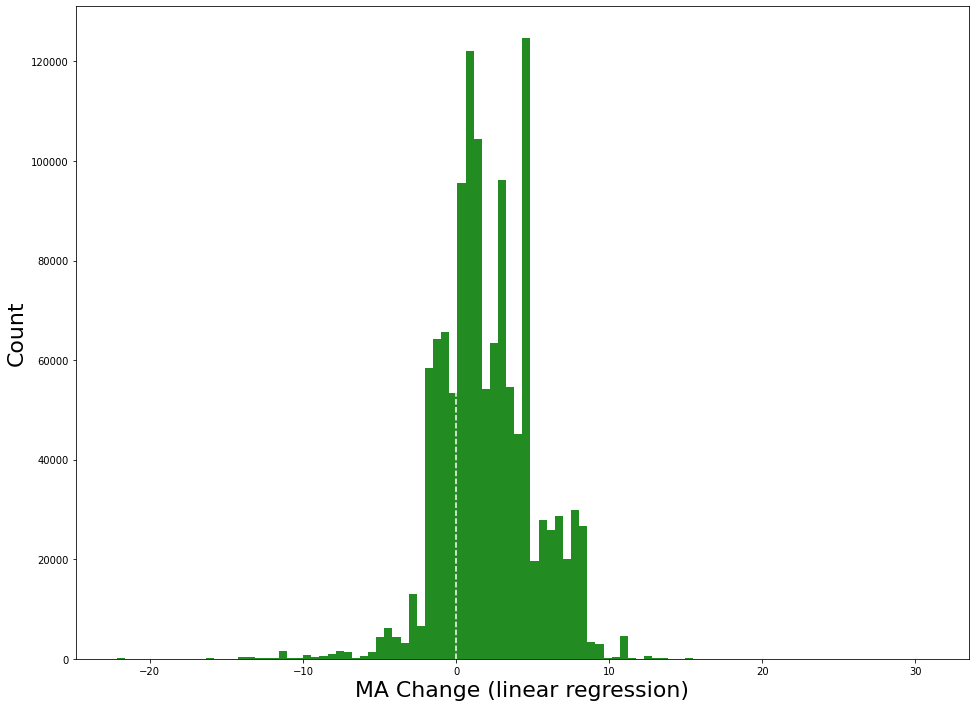

In [12]:
#Alternative graphing (finding slope change in MA)
linear_regressor = LinearRegression()

classification_MA_slopes = []

for c in tqdm(list(results_df["filtered_classification"].unique())):
    sub_df = results_df[results_df["filtered_classification"] == c]
    if len(sub_df) > 10:

        X = sub_df["date_ordinal"].values.reshape(-1,1)
        Y = sub_df["MA_avg"].values.reshape(-1,1)
        try:
            reg = linear_regressor.fit(X, Y)
            Y_pred = linear_regressor.predict(X)

            #Calculate deltaMA (change in MA of linear regression, taking into consideration negative slopes)
            classification_MA_slopes.extend([reg.coef_[0][0] * (max(X) - min(X))[0]]*len(sub_df))
                        
        except ValueError as e:
            pass

plt.figure(figsize=(16,12))


plt.hist(classification_MA_slopes, bins=100, color="forestgreen")
plt.axvline(x=0, ymin=0, ymax=70, color="white", linestyle="--")
plt.xlabel("MA Change (linear regression)", fontsize=22)
plt.ylabel("Count", fontsize=22)


100%|██████████| 2923/2923 [04:53<00:00,  9.96it/s]


Text(0, 0.5, 'Count')

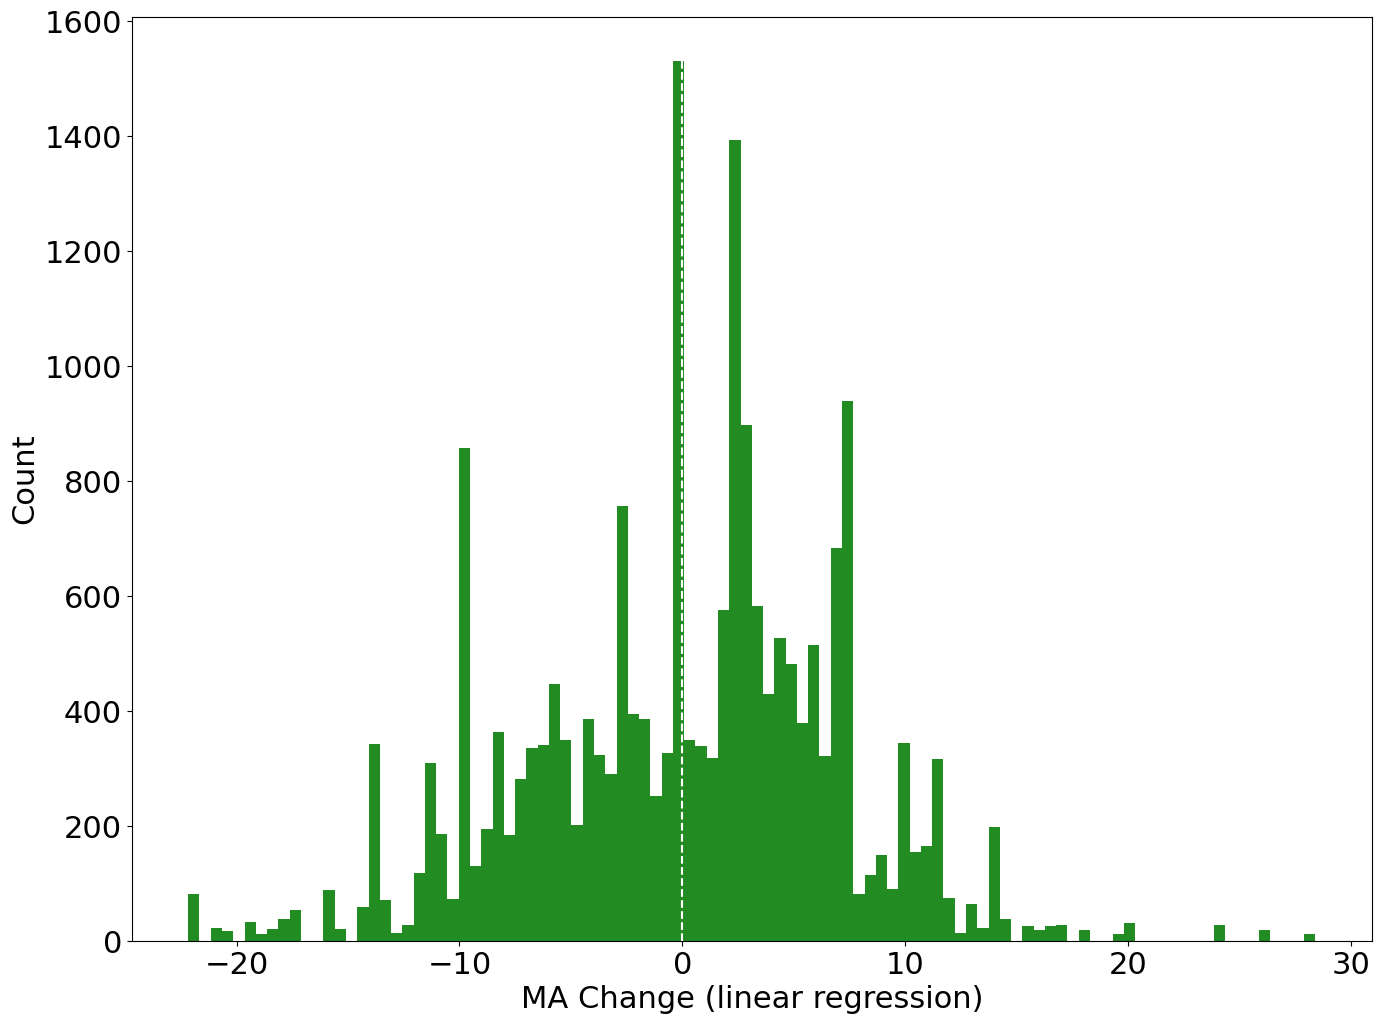

In [12]:
#Alternative graphing (finding slope change in MA)
linear_regressor = LinearRegression()

classification_MA_slopes = []

for c in tqdm(list(results_df["filtered_classification"].unique())):
    sub_df = results_df[results_df["filtered_classification"] == c]
    if len(sub_df) > 10:

        X = sub_df["date_ordinal"].values.reshape(-1,1)
        Y = sub_df["MA_avg"].values.reshape(-1,1)
        try:
            reg = linear_regressor.fit(X, Y)
            Y_pred = linear_regressor.predict(X)

            r2 = reg.score(X,Y)

            if r2 >= 0.25:
                #Calculate deltaMA (change in MA of linear regression, taking into consideration negative slopes)
                classification_MA_slopes.extend([reg.coef_[0][0] * (max(X) - min(X))[0]]*len(sub_df))
                        
        except ValueError as e:
            pass

plt.figure(figsize=(16,12))


plt.hist(classification_MA_slopes, bins=100, color="forestgreen")
plt.axvline(x=0, ymin=0, ymax=70, color="white", linestyle="--")
plt.xlabel("MA Change (linear regression)", fontsize=22)
plt.ylabel("Count", fontsize=22)


In [27]:
# Check percentile of 0
print("Percentile of 0 value", stats.percentileofscore(classification_MA_slopes, 0, kind="rank"))
print("Mean:", np.mean(classification_MA_slopes))
print("Std:", np.std(classification_MA_slopes))

Percentile of 0 value 21.552234698459344
Mean: 2.1479832168081
Std: 3.0609142237426346


## Full Figure

Price & Degree on top (with inset in price), and the three histograms on bottom

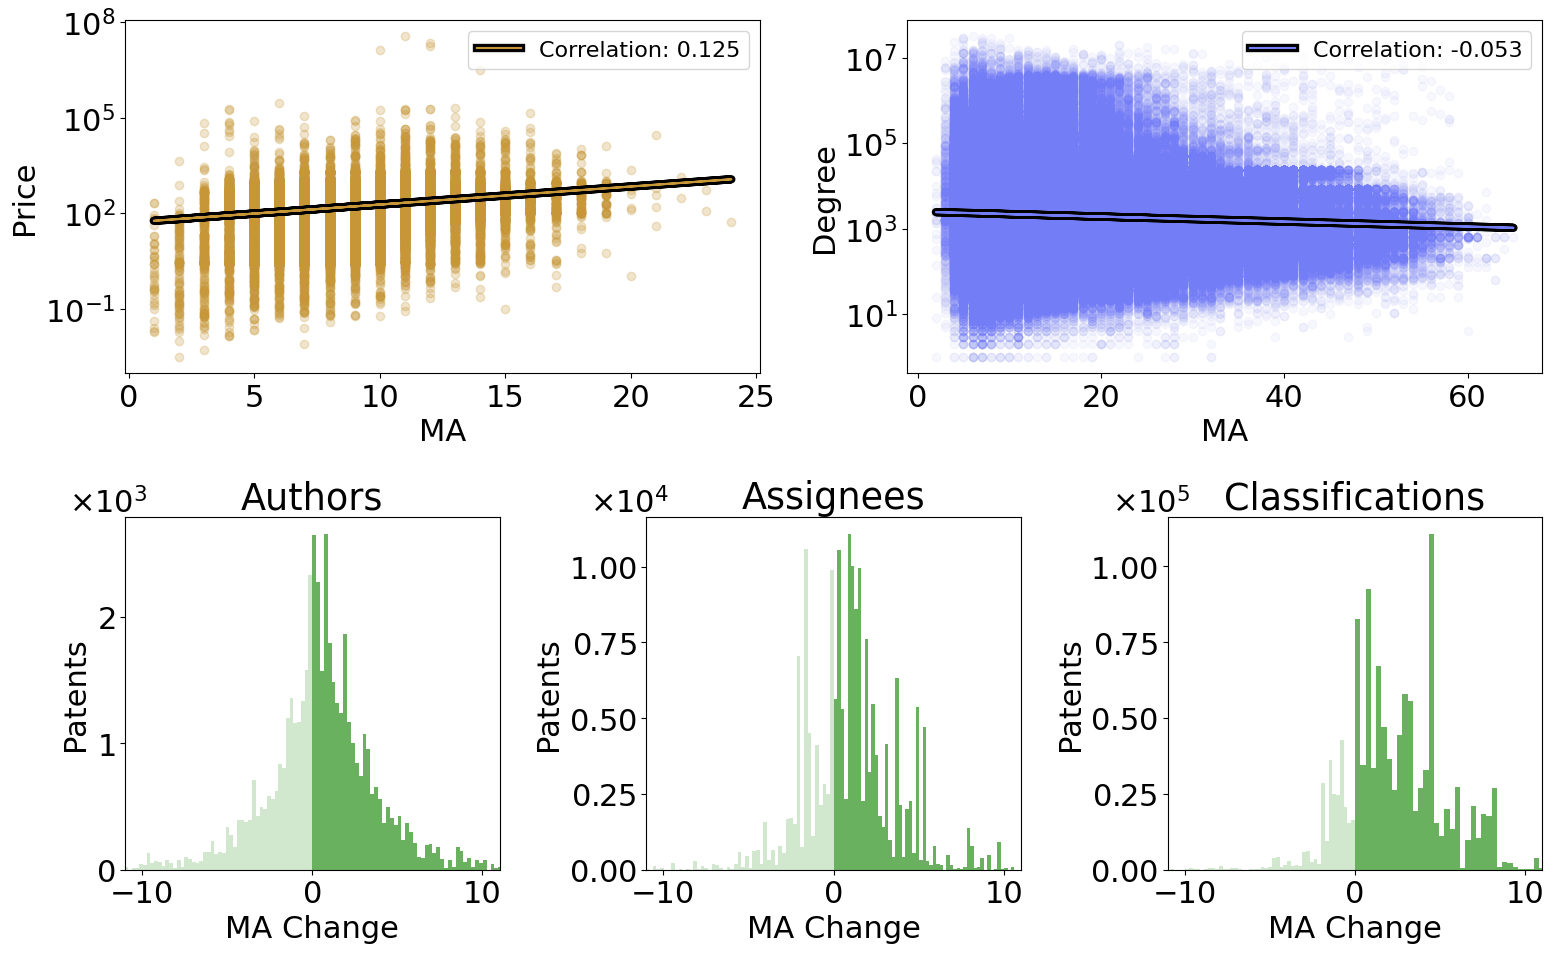

In [26]:
palette = ["#e072b5",
"#69b15f",
"#737df6",
"#c79737",
"#b67ae4",
"#e57368",
"#799ddb"]

gs = gridspec.GridSpec(2,6)

fig = plt.figure(figsize=(16,10))

## Cost 
ax1 = fig.add_subplot(gs[0,0:3])

cost_df_filtered = cost_df_filtered.sort_values("price")

ax1.scatter(cost_df_filtered["MA"], cost_df_filtered["price"], alpha=0.25, color=palette[3])

slope, intercept = np.polyfit(cost_df_filtered["MA"], np.log(cost_df_filtered["price"]), 1)

##Calculate Pearson correlation & Spearman (not assuming normality)
spearman_corr = stats.spearmanr(cost_df_filtered["MA"], cost_df_filtered["price"])

ax1.plot(cost_df_filtered["MA"], np.exp((slope*cost_df_filtered["MA"]) + intercept), color=palette[3],
        label="Correlation: " + str(round(spearman_corr[0], 3)), 
        path_effects=[pe.Stroke(linewidth=6, foreground="k"), pe.Normal()])

ax1.set_yscale("log")
ax1.set_xlabel("MA")
ax1.set_ylabel("Price")
ax1.legend(prop={"size":16}, loc="upper right")

## Degree
ax2 = fig.add_subplot(gs[0,3:])

ax2.scatter(MA_df_filtered["MA_assemblyGo"], MA_df_filtered["degree"], color=palette[2], alpha=0.05)

slope, intercept = np.polyfit(MA_df_filtered["MA_assemblyGo"], np.log(MA_df_filtered["degree"]), 1)

##Calculate Spearman correlation (not assuming normality)
spearman_corr = stats.spearmanr(MA_df_filtered["MA_assemblyGo"], MA_df_filtered["degree"])

ax2.plot(MA_df_filtered["MA_assemblyGo"], np.exp((slope*MA_df_filtered["MA_assemblyGo"]) + intercept), 
        color=palette[2], label="Correlation: " + str(round(spearman_corr[0], 3)),
        path_effects=[pe.Stroke(linewidth=6, foreground="k"), pe.Normal()])

ax2.set_yscale("log")
ax2.set_xlabel("MA")
ax2.set_ylabel("Degree")
ax2.legend(prop={"size":16}, loc="upper right")

## Author histogram
ax3 = fig.add_subplot(gs[1,0:2])

ax3.hist([x for x in author_MA_slopes if x <= 0], bins=100, color=palette[1], alpha=0.3)
ax3.hist([x for x in author_MA_slopes if x > 0], bins=100, color=palette[1])
# ax3.axvline(x=0, ymin=0, ymax=70, color="white", linestyle="--", linewidth=3)

ax3.set_xlabel("MA Change")
ax3.set_ylabel("Patents")
ax3.set_xbound(-11, 11)
ax3.set_title("Authors")
ax3.ticklabel_format(axis="y", style="sci", scilimits=(-2,2))
ax3.yaxis.major.formatter._useMathText = True
ax3.get_yaxis().get_offset_text().set_position((-0.15, 0))

## Assignee histogram
ax4 = fig.add_subplot(gs[1,2:4])

ax4.hist([x for x in assignee_MA_slopes if x <= 0], bins=100, histtype="bar", color=palette[1], alpha=0.3)
ax4.hist([x for x in assignee_MA_slopes if x > 0], bins=100, histtype="bar", color=palette[1])
# ax4.axvline(x=0, ymin=0, ymax=70, color="white", linestyle="--", linewidth=3)

ax4.set_xlabel("MA Change")
ax4.set_ylabel("Patents")
ax4.set_xbound(-11, 11)
ax4.set_title("Assignees")
ax4.ticklabel_format(axis="y", style="sci", scilimits=(-2,2))
ax4.yaxis.major.formatter._useMathText = True
ax4.get_yaxis().get_offset_text().set_position((-0.15, 0))


## Classification histogram
ax5 = fig.add_subplot(gs[1,4:])

ax5.hist([x for x in classification_MA_slopes if x <= 0], bins=100, histtype="bar", color=palette[1], alpha=0.3)
ax5.hist([x for x in classification_MA_slopes if x > 0], bins=100, histtype="bar", color=palette[1])
# ax5.axvline(x=0, ymin=0, ymax=70, color="white", linestyle="--", linewidth=3)

ax5.set_xlabel("MA Change")
ax5.set_ylabel("Patents")
ax5.set_xbound(-11, 11)
ax5.set_title("Classifications")
ax5.ticklabel_format(axis="y", style="sci", scilimits=(-2,2))
ax5.yaxis.major.formatter._useMathText = True
ax5.get_yaxis().get_offset_text().set_position((-0.15, 0))


plt.tight_layout()


## Expected MA change - Authors / Assignees / Classifications

How different than expected are the results for A/A/Cs?

1. Calculate avg/stdev of patents per A/A/C
2. Calculate avg/stdev number of cpds per patent
3. Calculate avg/stdev of length of "career" per A/A/C
4. Build model gaussian distributions for patents & length per A/A/C, and number of cpds per patent
5. Build model gaussian distribution of MA values per month (from chemical properties.ipynb)
6. For each type in A/A/C, do this 100x:

- Build n (number of A/A/Cs) profiles 
- Each profile containing p patents (sampled from patent per A/A/C gaussian), each patent containing c cpds (sampled from cpd per patent gaussian)
- C cpds have timestamps, uniformly sampled from length per A/A/C
- For each c cpd & timestamp t, sample a MA value from MA values per given month gaussian
- Calculate expected MA change for profile
- Summary statistics over n profiles

7.Summary statistics over 100 repetitions

In [17]:
counts = results_df["author"].value_counts()
print("Num authors:", len([x for x in counts if x >= 10]))

counts = results_df["assignees"].value_counts()
print("Num assignees:", len([x for x in counts if x >= 10]))

counts = results_df["filtered_classification"].value_counts()
print("Num classifications:", len([x for x in counts if x >= 10]))

Num authors: 30746
Num assignees: 769
Num classifications: 2036


In [60]:
### Avg/std of compounds per patent (applies across all A/A/Cs)

cpds_per_patent = []

MAs = list(results_df["MAs"].unique())

for entry in tqdm(MAs):
    cpds_per_patent.append(len(ast.literal_eval(entry)))

print(cpds_per_patent)

100%|██████████| 36047/36047 [00:08<00:00, 4255.36it/s]

[3, 334, 3381, 3448, 1185, 510, 1641, 116, 42, 62, 63, 12, 42, 6, 47, 21, 15, 107, 18, 5, 38, 53, 602, 27, 3808, 22, 168, 141, 533, 6, 28, 47, 15, 264, 181, 249, 122, 71, 4, 16, 8, 13, 3, 16, 34, 146, 4, 10, 17, 2, 31, 42, 50, 70, 180, 19, 543, 1, 34, 18, 153, 212, 84, 85, 83, 103, 132, 74, 84, 44, 148, 83, 94, 134, 251, 101, 136, 95, 298, 113, 161, 40, 100, 179, 58, 213, 140, 348, 89, 26, 70, 123, 116, 142, 13, 38, 103, 160, 394, 4221, 458, 1639, 467, 194, 14, 57, 122, 38, 2, 83, 50, 60, 83, 43, 75, 19, 19, 94, 319, 111, 48, 20, 34, 40, 24, 22, 16, 24, 12, 17, 37, 506, 364, 574, 1385, 4, 43, 61, 52, 55, 61, 18, 172, 164, 25, 162, 196, 204, 99, 165, 50, 93, 5, 139, 83, 43, 11, 44, 48, 22, 39, 34, 393, 17, 529, 7, 364, 912, 1306, 238, 187, 15, 8, 7, 2, 23, 22, 363, 62, 77, 59, 33, 44, 43, 63, 52, 70, 73, 60, 59, 1289, 182, 22, 67, 69, 162, 106, 115, 2, 11, 272, 11, 57, 23, 52, 37, 70, 7, 3, 10, 13, 17, 137, 142, 74, 65, 567, 481, 393, 16, 16, 39, 34, 5, 8, 104, 1, 3, 1, 238, 306, 2, 4, 

In [61]:
avg_cpds_per_patent = np.mean(cpds_per_patent)
stdev_cpds_per_patent = np.std(cpds_per_patent)

In [62]:
print(f"Avg Cpds Per Patent: {avg_cpds_per_patent}, Stdev: {stdev_cpds_per_patent}")

Avg Cpds Per Patent: 108.41867561794324, Stdev: 272.51858323850996


### Start with assignees

Because this is the fewest amount - use this to see how long this takes, and go from here

In [20]:
### Calculate avg/stdev of patents per assignee

patents_per_assignee = []

for assignee in tqdm(list(results_df["assignees"].unique())):
    sub_df = results_df[results_df["assignees"] == assignee]
    if len(sub_df) > 10:
        patents_per_assignee.append(len(sub_df))

avg_patents_per_assignee = np.mean(patents_per_assignee)
stdev_patents_per_assignee = np.std(patents_per_assignee)

print(f"Avg Patents: {avg_patents_per_assignee}, Stdev: {stdev_patents_per_assignee}")

100%|██████████| 833/833 [01:26<00:00,  9.59it/s]

Avg Patents: 1628.3015665796345, Stdev: 4235.928408835023


In [21]:
print(f"Avg Patents: {avg_patents_per_assignee}, Stdev: {stdev_patents_per_assignee}")

Avg Patents: 1628.3015665796345, Stdev: 4235.928408835023


In [80]:
### Calculate avg number of months between first and last patent

assignee_lengths =[]

for assignee in tqdm(list(results_df["assignees"].unique())):
    sub_df = results_df[results_df["assignees"] == assignee]
    if len(sub_df) > 10:
        sub_df = results_df[results_df["assignees"] == assignee]
        format = "%Y-%m-%d"
        start_date = datetime.datetime.strptime(min(sub_df["date"]), format)
        end_date = datetime.datetime.strptime(max(sub_df["date"]), format)

        assignee_lengths.append((end_date.year - start_date.year) * 12 + end_date.month - start_date.month)

print(assignee_lengths)


100%|██████████| 833/833 [02:37<00:00,  5.30it/s]

[88, 338, 215, 306, 373, 405, 230, 299, 184, 210, 246, 90, 223, 258, 420, 97, 383, 83, 167, 298, 239, 290, 151, 236, 64, 180, 410, 52, 485, 490, 194, 150, 174, 491, 264, 416, 490, 301, 240, 265, 482, 488, 183, 491, 154, 477, 446, 490, 477, 477, 377, 300, 488, 488, 320, 481, 418, 239, 479, 468, 486, 108, 491, 380, 292, 271, 472, 485, 247, 166, 334, 336, 122, 52, 70, 138, 360, 262, 477, 238, 425, 491, 157, 302, 382, 400, 366, 316, 229, 65, 210, 10, 233, 277, 282, 191, 66, 179, 357, 192, 69, 375, 299, 422, 320, 438, 296, 391, 200, 453, 384, 189, 366, 488, 240, 272, 52, 446, 362, 309, 204, 349, 286, 383, 59, 243, 170, 88, 487, 400, 0, 29, 487, 75, 113, 199, 480, 387, 67, 400, 201, 434, 194, 285, 331, 477, 315, 457, 102, 168, 86, 241, 97, 324, 126, 59, 315, 147, 272, 121, 128, 304, 365, 474, 167, 396, 169, 243, 222, 244, 231, 238, 469, 146, 66, 418, 441, 99, 163, 466, 466, 125, 47, 299, 50, 276, 227, 410, 51, 26, 292, 19, 349, 100, 244, 74, 206, 51, 153, 90, 146, 0, 417, 114, 221, 102, 479,

In [82]:
avg_months_per_assignee = np.mean(assignee_lengths)
std_months_per_assignee = np.std(assignee_lengths)

print(f"Avg Length: {avg_months_per_assignee}, Stdev: {std_months_per_assignee}")

Avg Length: 165.89817232375978, Stdev: 140.20531409721332


In [43]:
### Build 769 profiles ("companies"), with p patents sampled from Gaussian (re-sample negative values as needed)

profile_patent_size = []
while len(profile_patent_size) != 769:
    p = np.random.normal(avg_patents_per_assignee, stdev_patents_per_assignee, 1)[0]
    if p > 0:
        profile_patent_size.append(math.floor(p))

print(profile_patent_size)

[4026, 3247, 5814, 7624, 2891, 2934, 922, 8928, 5364, 3470, 4291, 1105, 638, 4566, 1465, 2163, 4564, 3246, 3393, 4829, 3093, 1915, 1640, 5146, 266, 5173, 3977, 11506, 4867, 193, 2145, 1261, 1590, 2867, 2480, 9414, 338, 764, 333, 2867, 7081, 146, 4666, 2469, 4018, 475, 1915, 3103, 1438, 3226, 1344, 4504, 6044, 8653, 3188, 8186, 3159, 339, 903, 1233, 3695, 7367, 10060, 1350, 2159, 5219, 4999, 6132, 4877, 950, 3427, 2222, 2570, 3426, 6133, 322, 2575, 4482, 1730, 3225, 1416, 2218, 11856, 1045, 7352, 8225, 757, 7334, 296, 4102, 604, 5547, 592, 4819, 2278, 3380, 3838, 1058, 3886, 7790, 5986, 7359, 745, 1439, 3945, 7821, 1714, 6426, 1193, 1059, 6414, 10581, 475, 7143, 2481, 2605, 209, 2540, 2676, 7057, 5860, 5079, 2278, 2993, 4235, 132, 3675, 1836, 1164, 2639, 5173, 4987, 10922, 7278, 7502, 411, 3464, 2081, 3191, 4421, 8436, 6233, 3953, 2180, 1666, 5803, 4465, 4361, 3036, 10676, 1491, 6816, 4233, 2718, 4167, 2804, 9968, 4077, 487, 12169, 2496, 2044, 7460, 5166, 8227, 1758, 6136, 12554, 5325, 

In [192]:
### Calculate random dates in YYYY-MM-DD format (from https://stackoverflow.com/questions/50559078/generating-random-dates-within-a-given-range-in-pandas)

def random_dates2(start, end, n, unit='D', seed=None):
    ndays = (end - start).days + 1
    return start + pd.to_timedelta(
        np.random.randint(0, ndays, n), unit=unit
    )

In [242]:
def get_starting_time(months, num_timestamps):
    """ Generate a random starting time for a given "profile" - this is the date of the first patent

    Samples are guaranteed to be between Jan 1976 & (Dec 2022 - number of months)

    Args:
        months (int): number of months that a particular profile exists for
        num_patents (int): how many timestamps should be generated

    Returns:
        (list of pyDateTime objects): randomly generated samples, all in pyDateTime format with year, month, and date
    """
    low_range = datetime.datetime(year=1976, month=1, day=1)
    high_range = datetime.datetime(year=2022, month=12, day=31) - relativedelta(months = months, day=0)

    #Generate a random starting date, between the low & high range
    start_date = random_dates2(low_range, high_range, 1, seed=random.randint).to_pydatetime()[0]
        
    ## Randomly generate num_patents numbers of timestamps
    return start_date

In [246]:
### For each profile, calculate starting and ending time

# List of list data structure: [[t_start, t_end], [t_start, t_end], ..., [t_start, t_end]], 
# t is a timestamp, start/end is the starting and ending timestamp of that particular "company" profile

profile_timestamps = []

for i in tqdm(range(len(profile_patent_size))):
    #Sample number of months
    num_months = np.random.normal(avg_months_per_assignee, std_months_per_assignee, 1)[0]
    #Ensure number of months isn't larger than the total size of the dataset, or is negative
    while num_months > 556 or num_months < 1:
        num_months = np.random.normal(avg_months_per_assignee, std_months_per_assignee, 1)[0]

    #Sample number of compounds per patent
    starting_timestamp = get_starting_time(math.floor(num_months), 1)
    ending_timestamp = starting_timestamp + relativedelta(months=math.floor(num_months), day=0)
    
    profile_timestamps.append((starting_timestamp, ending_timestamp))

100%|██████████| 769/769 [00:00<00:00, 1811.28it/s]

(datetime.datetime(1981, 4, 28, 0, 0), datetime.datetime(1998, 1, 28, 0, 0))


In [247]:
print(profile_timestamps[0])

(datetime.datetime(1981, 4, 28, 0, 0), datetime.datetime(1998, 1, 28, 0, 0))


In [255]:
### For each profile, generate timestamps of all patents

# Data structure: list of lists, each sublist with n timestamps (n from profile_patent_size)

profile_patent_timestamps = []

# Loop through patent sizes (number of patents per company), and starting & ending point
for i in tqdm(range(len(profile_patent_size))):
    #Generate a list of timestamps for patents, uniformly sampled from within the starting & ending point of the "company"
    timestamps = random_dates2(profile_timestamps[i][0], profile_timestamps[i][1], 
                               profile_patent_size[i], seed=random.randint).to_pydatetime()
    
    profile_patent_timestamps.append(timestamps)

100%|██████████| 769/769 [00:02<00:00, 256.76it/s]


In [260]:
print(profile_patent_timestamps[0], "\n", len(profile_patent_timestamps[0]))

[datetime.datetime(1984, 12, 17, 0, 0) datetime.datetime(1992, 8, 4, 0, 0)
 datetime.datetime(1997, 8, 31, 0, 0) ...
 datetime.datetime(1990, 6, 8, 0, 0) datetime.datetime(1993, 12, 22, 0, 0)
 datetime.datetime(1995, 4, 15, 0, 0)] 
 4026


In [327]:
def get_MA_from_timestamp(timestamp, MA_month_avg_dict, MA_month_std_dict, n_cpds):
    """ Calculates a list of expected MAs from a given timestamp

    Args:
        timestamp (datetime.datetime object): Specific date of a random "patent"
        MA_df (pandas dataframe): holds MA avg & std dev values at each month
        n_cpds (int): number of compounds in a given patent
    """
    
    #Get year & month of timestamp
    month = timestamp.month
    if month < 10:
        month = "0" + str(timestamp.month)
    else:
        month = str(timestamp.month)
        
    MA_avg = MA_month_avg_dict[str(timestamp.year) + "-" + month]
    MA_std = MA_month_std_dict[str(timestamp.year) + "-" + month]

    lower = 1
    upper = 1000 #upper value set to be arbitarily high
    
    MAs = stats.truncnorm.rvs((lower-MA_avg)/MA_std,(upper-MA_avg)/MA_std,loc=MA_avg,scale=MA_std,size=n_cpds)
    #MAs = np.random.normal(avg_cpds_per_patent, stdev_cpds_per_patent, n_cpds)

    return MAs
    

In [315]:
get_MA_from_timestamp(profile_patent_timestamps[0][0], MA_month_avg_dict, MA_month_std_dict, 100)

1984 12
[15.95650173 16.71697191 18.99185527 11.44657557 12.84219102  9.56202705
 10.8762053  13.17799806  7.57219742 18.56666911 18.35495248 14.47001564
  8.37863511 17.8942819  12.00488487  1.02182022  9.77343607 10.38947423
 12.21034989 12.69775673  9.69711999 16.09459624  4.51173631 13.42729248
  1.41814631 19.34814887  4.05781351 17.14438046 13.75751723  6.28655357
 12.88262063 18.98320171  5.93688655 12.80081219  7.6806624  10.46723339
 10.1786439   8.78041838 16.78458793 14.50927603 15.63747743 11.69311445
  8.15007494 19.32390002 18.83616764 11.3480444  15.30377877 20.82194887
 13.06894944 20.71637324 13.54500512  8.54520905 20.5033268  24.33728686
 18.14346137 18.9701974   8.91282239 14.96612495  5.2318269  19.48466491
 15.62671037 24.22831742 17.69739973 17.89616853 15.35476418 17.78106179
  8.70468031 18.38705899 12.42538669 14.46146378  5.19681676 20.77916193
  4.70096862 19.01224213 17.37135913 19.00816707  5.03764194 17.52316722
  8.63512255 24.85378066 20.78187158 11.623

In [297]:
MA_df = pd.read_csv("../Data/AssemblyValues/MA_df_months.csv")

MA_month_avg_dict = dict(zip(MA_df.month, MA_df.avg))
MA_month_std_dict = dict(zip(MA_df.month, MA_df.stdev))

print(MA_month_avg_dict)
print(MA_month_std_dict)


{'1965-02': 17.5, '1965-05': 7.0, '1965-06': 9.0, '1966-03': 6.0, '1966-07': 6.0, '1967-12': 14.0, '1971-08': 17.0, '1972-03': 7.0, '1973-01': 9.149253731343284, '1973-02': 11.84375, '1973-03': 9.158730158730158, '1973-04': 8.2, '1973-05': 7.979166666666667, '1973-06': 9.293333333333331, '1973-07': 9.4375, '1973-08': 10.015873015873016, '1973-09': 8.141304347826088, '1973-10': 10.87, '1973-11': 8.608108108108109, '1973-12': 9.097560975609756, '1974-01': 9.22222222222222, '1974-02': 9.824561403508772, '1974-03': 10.484848484848484, '1974-04': 10.975609756097562, '1974-05': 10.666666666666666, '1974-06': 10.090909090909092, '1974-07': 9.818181818181818, '1974-08': 9.4, '1974-09': 8.935483870967742, '1974-10': 8.555555555555555, '1974-11': 10.456521739130435, '1974-12': 9.23076923076923, '1975-01': 8.755395683453237, '1975-02': 8.88888888888889, '1975-03': 9.217142857142855, '1975-04': 9.483870967741936, '1975-05': 8.701863354037267, '1975-06': 9.87912087912088, '1975-07': 9.1296296296296

In [330]:
### Get timestamps of compounds - multiply each timestamp by the number of compounds within a patent

# Data structure - list of lists, each sublist with n * [c0, c1, c2, ...] timestamps 
# (n = number of patents, [c0, c1, ..] = number of compounds per patent)

profile_MAs = []

for profile in tqdm(profile_patent_timestamps[0:1]):
    MAs = []
    for timestamp in profile:
        ## Get number of compounds per patent
        n_cpds = num_months = np.random.normal(avg_cpds_per_patent, stdev_cpds_per_patent, 1)[0]
        while n_cpds < 1:
            n_cpds = num_months = np.random.normal(avg_cpds_per_patent, stdev_cpds_per_patent, 1)[0]

        MAs.append(get_MA_from_timestamp(timestamp, MA_month_avg_dict, MA_month_std_dict, math.floor(n_cpds)))

    profile_MAs.append(MAs)

print(len(profile_MAs[0][0]))


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

172


In [331]:
### NEXT STEPS: analyze delta MAs

"""
Also make sure this is doing what I want it to - ideally, this should be a list of MAs for every "patent". 

The analysis, along with the timestamps of each patent, should allow for easy delta MA calculations. 

Come back to this (tomorrow, 7/4) to make sure this all makes sense!
"""

'\nAlso make sure this is doing what I want it to - ideally, this should be a list of MAs for every "patent". \n\nThe analysis, along with the timestamps of each patent, should allow for easy delta MA calculations. \n\nCome back to this (tomorrow, 7/4) to make sure this all makes sense!\n'